In [1]:
#Step 1: Import all essential libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Convolution2D,MaxPooling2D,Flatten,Lambda
from keras.optimizers import Adam
from keras.models import model_from_json
import json
import csv
%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.python.control_flow_ops = tf

In [3]:
#Step 2: Define Epochs, Learning Size, Training Size and Validation Size
#Find the number if images to train in the model
import os
# data_directory = '/Users/mounteverest/Desktop/CarND/DrivingLogs/IMG_HARD'
# driving_log = '/Users/mounteverest/Desktop/CarND/DrivingLogs/driving_log_hard.csv'
data_directory = '/Users/mounteverest/Desktop/CarND/IMG'
driving_log = '/Users/mounteverest/Desktop/CarND/driving_log.csv'

# data_directory = '/Users/mounteverest/Desktop/CarND/CarNDProjects/CarND-Behavioral-Cloning-P3/data/IMG'
# driving_log = '/Users/mounteverest/Desktop/CarND/CarNDProjects/CarND-Behavioral-Cloning-P3/data/driving_log.csv'
image_count = len([name for name in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, name))])
print("Image Count:", image_count)
epochs = 8
training_sample_size = len([name for name in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, name))]) * 0.70
validation_sample_size = image_count - training_sample_size
learning_rate = 0.0001
activation_relu = 'relu'
print("Training Size:",int(training_sample_size))
print("Validation Size:", int(validation_sample_size))

Image Count: 7242
Training Size: 5069
Validation Size: 2172


In [4]:
#Step 2: Read files to identify left, center and right images
#Manually added header to the driving log CSV file generated from simulator
training_data = pd.read_csv(driving_log, names=None)
X_train = training_data['center']
X_left  = training_data['left']
X_right = training_data['right']
Y_train = training_data['steering']
training_data.head()

,center,left,right,steering,throttle,brake,speed
0,/Users/mounteverest/Desktop/CarND/IMG/center_2...,/Users/mounteverest/Desktop/CarND/IMG/left_201...,/Users/mounteverest/Desktop/CarND/IMG/right_20...,0.0,0.0,0,0.000015
1,/Users/mounteverest/Desktop/CarND/IMG/center_2...,/Users/mounteverest/Desktop/CarND/IMG/left_201...,/Users/mounteverest/Desktop/CarND/IMG/right_20...,0.0,0.0,0,0.000010
2,/Users/mounteverest/Desktop/CarND/IMG/center_2...,/Users/mounteverest/Desktop/CarND/IMG/left_201...,/Users/mounteverest/Desktop/CarND/IMG/right_20...,0.0,0.0,0,0.000008
3,/Users/mounteverest/Desktop/CarND/IMG/center_2...,/Users/mounteverest/Desktop/CarND/IMG/left_201...,/Users/mounteverest/Desktop/CarND/IMG/right_20...,0.0,0.0,0,0.000010
4,/Users/mounteverest/Desktop/CarND/IMG/center_2...,/Users/mounteverest/Desktop/CarND/IMG/left_201...,/Users/mounteverest/Desktop/CarND/IMG/right_20...,0.0,0.0,0,0.000003


training example m : 59
steering : -0.0671936692696


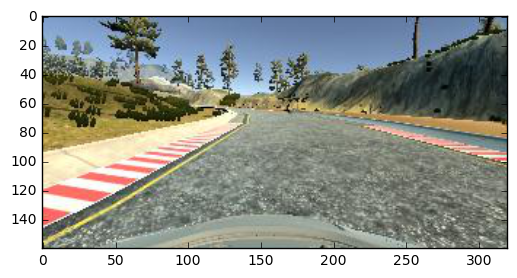

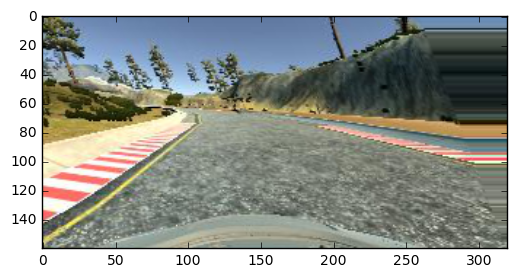

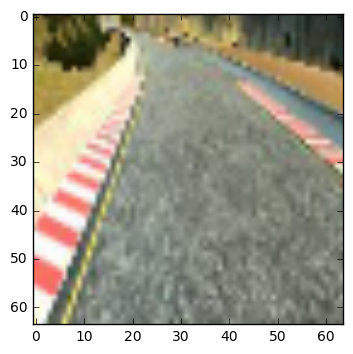

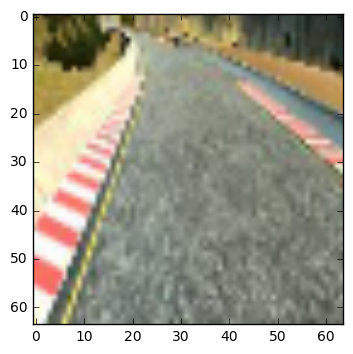

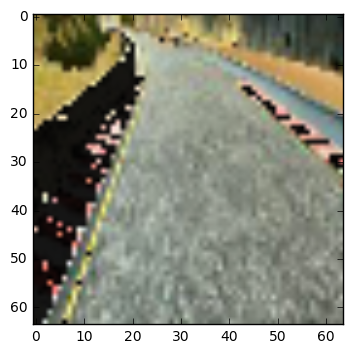

In [6]:
#Methods to generate training examples
def read_next_image(m,lcr,X_train,X_left,X_right,Y_train):
    # assume the side cameras are about 1.2 meters off the center and the offset to the left or right 
    # should be be corrected over the next dist meters, calculate the change in steering control
    # using tan(alpha)=alpha

    offset=1.2 
    dist=100.0
    steering = Y_train[m]
    if lcr == 0:
        image = plt.imread(X_left[m].strip())
        dsteering = -offset/dist * 360/( 2*np.pi) / 25.0
        steering += dsteering
    elif lcr == 1:
        image = plt.imread(X_train[m].strip())
    elif lcr == 2:
        image = plt.imread(X_right[m].strip())
        dsteering = offset/dist * 360/( 2*np.pi)  / 25.0
        steering += dsteering
    else:
        print ('Invalid lcr value :',lcr )
    
    return image,steering

def random_crop(image,steering=0.0,tx_lower=-20,tx_upper=20,ty_lower=-2,ty_upper=2,rand=True):
    # we will randomly crop subsections of the image and use them as our data set.
    # also the input to the network will need to be cropped, but of course not randomly and centered.
    shape = image.shape
    col_start,col_end =abs(tx_lower),shape[1]-tx_upper
    horizon=60;
    bonnet=136
    if rand:
        tx= np.random.randint(tx_lower,tx_upper+1)
        ty= np.random.randint(ty_lower,ty_upper+1)
    else:
        tx,ty=0,0
    
    #    print('tx = ',tx,'ty = ',ty)
    random_crop = image[horizon+ty:bonnet+ty,col_start+tx:col_end+tx,:]
    image = cv2.resize(random_crop,(64,64),cv2.INTER_AREA)
    # the steering variable needs to be updated to counteract the shift 
    if tx_lower != tx_upper:
        dsteering = -tx/(tx_upper-tx_lower)/20.0
    else:
        dsteering = 0
    steering += dsteering
    
    return image,steering

def random_shear(image,steering,shear_range):
    rows,cols,ch = image.shape
    dx = np.random.randint(-shear_range,shear_range+1)
    #    print('dx',dx)
    random_point = [cols/2+dx,rows/2]
    pts1 = np.float32([[0,rows],[cols,rows],[cols/2,rows/2]])
    pts2 = np.float32([[0,rows],[cols,rows],random_point])
    dsteering = dx/(rows/2) * 360/(2*np.pi*25.0) / 10.0    
    M = cv2.getAffineTransform(pts1,pts2)
    image = cv2.warpAffine(image,M,(cols,rows),borderMode=1)
    steering +=dsteering
    
    return image,steering

def random_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = 1.0 + 0.1*(2*np.random.uniform()-1.0)    
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def random_flip(image,steering):
    coin=np.random.randint(0,2)
    if coin==0:
        image,steering=cv2.flip(image,1),-steering
    return image,steering
        

def generate_training_example(X_train,X_left,X_right,Y_train):
    m = np.random.randint(0,len(Y_train))
    print('training example m :',m)
    lcr = np.random.randint(0,3)
#    print('left_center_right  :',lcr)
    image,steering = read_next_image(m,lcr,X_train,X_left,X_right,Y_train)
#    print('steering :',steering)
    plt.imshow(image)
    image,steering = random_shear(image,steering,shear_range=40)
#    print('steering :',steering)
    plt.figure()
    plt.imshow(image)    
    image,steering = random_crop(image,steering,tx_lower=-20,tx_upper=20,ty_lower=-2,ty_upper=2)
#    print('steering :',steering)
    plt.figure()
    plt.imshow(image)
    image,steering = random_flip(image,steering)
#    print('steering :',steering)
    plt.figure()
    plt.imshow(image)
    
    image = random_brightness(image)
    plt.figure()
    plt.imshow(image)
    
    return image,steering
    

image,steering = generate_training_example(X_train,X_left,X_right,Y_train)
plt.imshow(image)    
print('steering :',steering)

In [55]:
def generate_train_batch(X_train,X_left,X_right,Y_train,batch_size = 32):
    
    batch_images = np.zeros((batch_size, 64, 64, 3))
    batch_steering = np.zeros(batch_size)
    while 1:
        for i_batch in range(batch_size):
            x,y = generate_training_example(X_train,X_left,X_right,Y_train)
            batch_images[i_batch] = x
            batch_steering[i_batch] = y
        yield batch_images, batch_steering

batch_size=200
train_generator = generate_train_batch(X_train,X_left,X_right,Y_train,batch_size)

In [56]:
print('X_train data type :',X_train.dtype)
print('Y_train data type :',Y_train.dtype)

nb_filter1 = 32
nb_filter2 = 64
nb_filter3 = 128
# size of pooling area for max pooling
pool_size = (2, 2)
pool_strides = (1,1)
# convolution kernel size
kernel_size = (3, 3)
# number of hidden units in the first fully connected layer
nb_fc1=128
nb_fc2=128
epochs = 8

X_train data type : object
Y_train data type : float64


## Train Model

In [57]:
#Step 3: Define Model

In [58]:
model = Sequential()
model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(64, 64, 3)))
# starts with five convolutional and maxpooling layers
model.add(Convolution2D(24, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(36, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(48, 5, 5, border_mode='same', subsample=(2, 2)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Convolution2D(64, 3, 3, border_mode='same', subsample=(1, 1)))
model.add(Activation(activation_relu))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))

model.add(Flatten())

# Next, five fully connected layers
model.add(Dense(1164))
model.add(Activation(activation_relu))

model.add(Dense(100))
model.add(Activation(activation_relu))

model.add(Dense(50))
model.add(Activation(activation_relu))

model.add(Dense(10))
model.add(Activation(activation_relu))

model.add(Dense(1))

model.summary()

model.compile(optimizer=Adam(learning_rate), loss="mse")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 64, 64, 3)     0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
convolution2d_21 (Convolution2D) (None, 32, 32, 24)    1824        lambda_5[0][0]                   
____________________________________________________________________________________________________
activation_37 (Activation)       (None, 32, 32, 24)    0           convolution2d_21[0][0]           
____________________________________________________________________________________________________
maxpooling2d_21 (MaxPooling2D)   (None, 31, 31, 24)    0           activation_37[0][0]              
___________________________________________________________________________________________

In [59]:
#Fitting the model
epochs = 8
model_weights = "model.h5"
# model_name    = "model.json"
history = model.fit_generator(train_generator, samples_per_epoch=20000, nb_epoch=epochs, verbose=1)
# json_string = model.to_json()
# with open(model_name, 'w') as outfile:
#     json.dump(json_string, outfile)
model.save(model_weights)
# model.save_weights(model_weights)

Epoch 1/8
20000/20000 [==============================] - 157s - loss: 0.0327   
Epoch 2/8
20000/20000 [==============================] - 156s - loss: 0.0262   
Epoch 3/8
20000/20000 [==============================] - 162s - loss: 0.0253   
Epoch 4/8
20000/20000 [==============================] - 163s - loss: 0.0244   
Epoch 5/8
20000/20000 [==============================] - 179s - loss: 0.0233   
Epoch 6/8
20000/20000 [==============================] - 153s - loss: 0.0231   
Epoch 7/8
20000/20000 [==============================] - 154s - loss: 0.0236   
Epoch 8/8
20000/20000 [==============================] - 155s - loss: 0.0227   
